In [1]:
import numpy as np
import scipy.io as sio
from scipy import signal
from scipy.signal import butter, lfilter, iirnotch
from brainflow.board_shim import BoardShim, BrainFlowInputParams, BoardIds
import matplotlib.pyplot as plt

In [2]:
def butter_filter(data, cutoff, fs, btype='low', order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    y = lfilter(b, a, data, axis=0)
    return y

def notch_filter(signal, fs, freq=50, Q=30):
    b, a = iirnotch(freq, Q, fs)
    return lfilter(b, a, signal, axis=0)

In [3]:
debug = False

# Setting up the board
if debug:
    # Create a synthetic board for debugging purposes
    board_id = BoardIds.SYNTHETIC_BOARD
    params = BrainFlowInputParams()
else:
    # Setting up the board
    params = BrainFlowInputParams()
    params.serial_number = 'UN-2023.02.30'
    board_id = BoardIds.UNICORN_BOARD
    
board = BoardShim(board_id, params)

# Getting specific board details
channels = board.get_eeg_channels(board_id) #EEG Channels
timestamp_channel = board.get_timestamp_channel(board_id) # Timestamp channel
marker_channel = board.get_marker_channel(board_id) # Marker channel for synchronization
sampling_rate = BoardShim.get_sampling_rate(board_id) # Hz

In [4]:
dataset = np.loadtxt(r"..//eeg_data.csv", delimiter=",")

In [5]:
eegdata = dataset[:, channels]
eegdata.shape

(139006, 8)

In [6]:
avg = np.mean(eegdata, axis = 1, keepdims=True)
eegdata -= avg

In [7]:
for i in range(len(channels)):
    eegdata[:,i] = butter_filter(eegdata[:,i], 2, sampling_rate, 'high')
    eegdata[:,i] = butter_filter(eegdata[:,i], 30, sampling_rate, 'low')
    eegdata[:,i] = notch_filter(eegdata[:,i], sampling_rate, freq=60)

In [8]:
markers = dataset[:, marker_channel]

left = np.where(markers == 3)[0]
right = np.where(markers == 4)[0]
up = np.where(markers == 1)[0]
down = np.where(markers == 2)[0]
end = np.where(markers==67)[0]

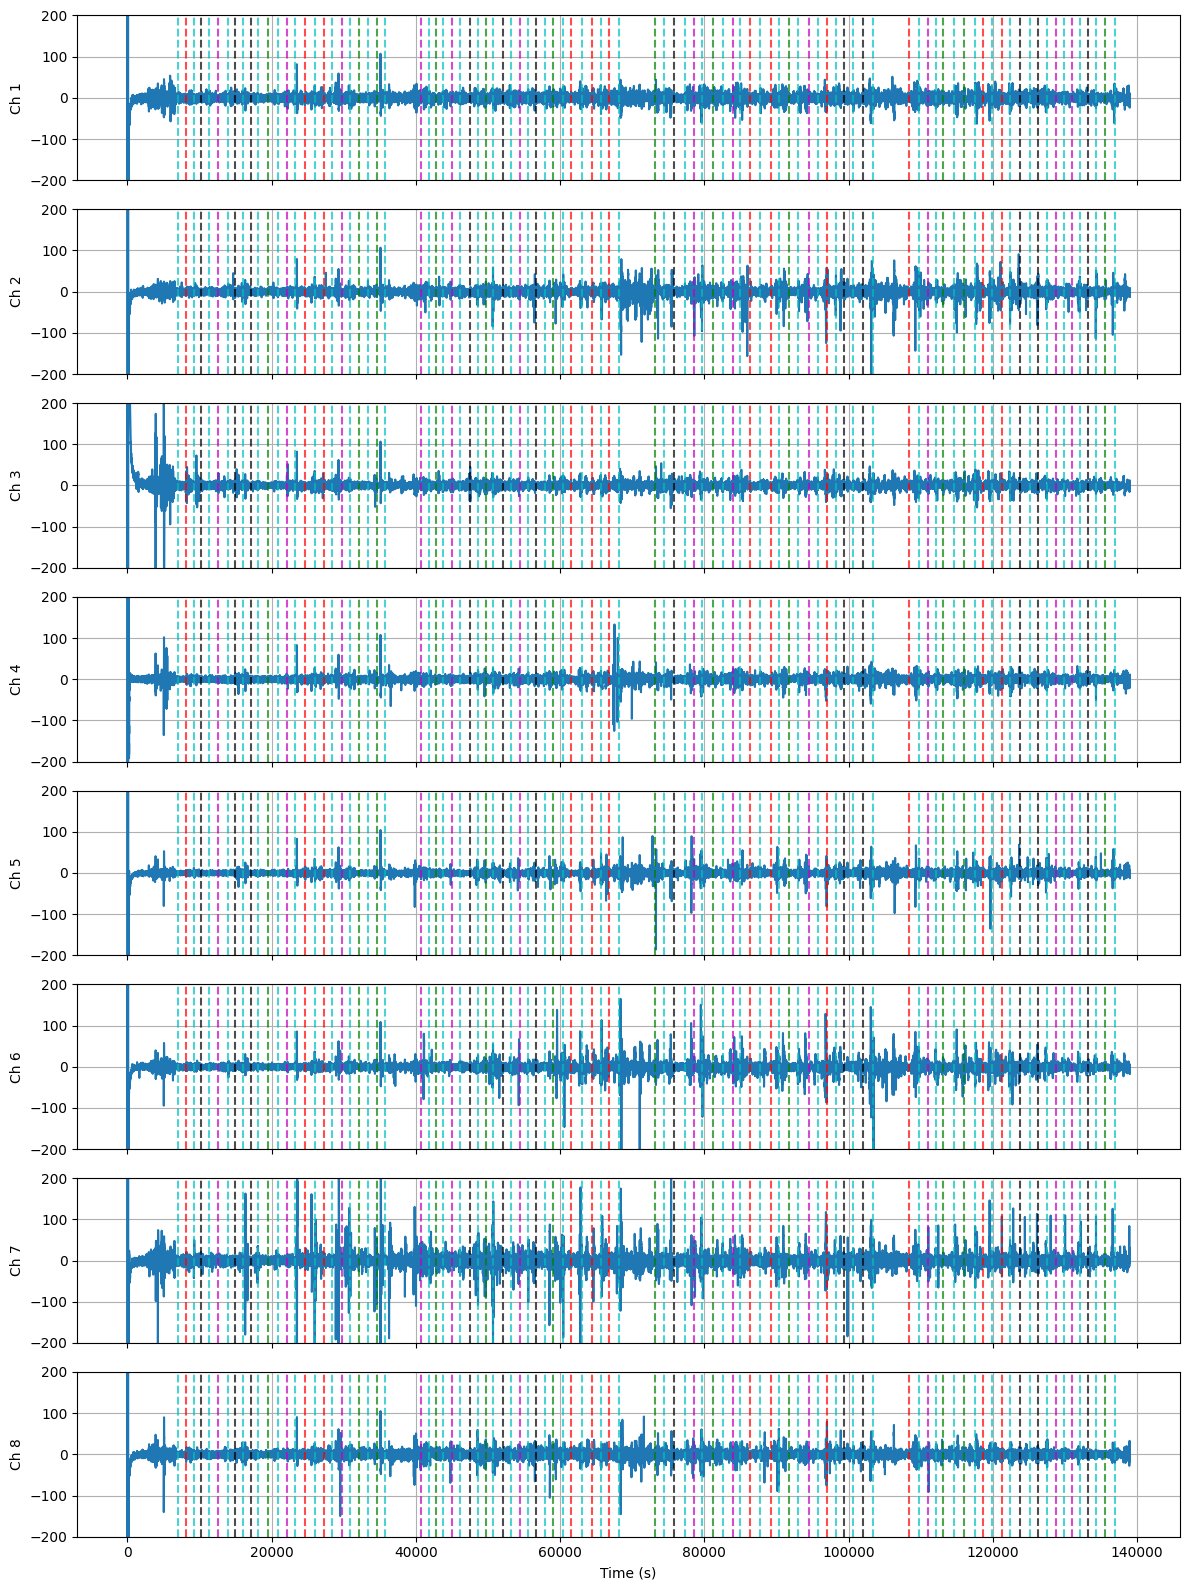

In [9]:
fig, axes = plt.subplots(len(channels), 1, figsize=(12, 2*len(channels)), sharex=True)

for i in range(len(channels)):
    axes[i].plot(eegdata[:, i])
    axes[i].set_ylabel(f"Ch {i+1}")
    axes[i].set_ylim(-200, 200)  # fix y-axis range if needed
    axes[i].grid(True)

    axes[i].vlines(left, ymin=-200, ymax=200, colors='r', linestyles='--', alpha=0.7)
    axes[i].vlines(right, ymin=-200, ymax=200, colors='g', linestyles='--', alpha=0.7)
    axes[i].vlines(up, ymin=-200, ymax=200, colors='k', linestyles='--', alpha=0.7)
    axes[i].vlines(down, ymin=-200, ymax=200, colors='m', linestyles='--', alpha=0.7)
    axes[i].vlines(end, ymin=-200, ymax=200, colors='c', linestyles='--', alpha=0.7)


axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

In [10]:
temp_idx = np.arange(0, len(markers))
temp_idx = temp_idx[markers != 0]
temp_idx = temp_idx[markers[temp_idx] != 67]



eeg_samples = []
labels = []

for i in range(len(temp_idx)):
    temp_eeg = eegdata[temp_idx[i]:temp_idx[i]+4*sampling_rate, :]
    
    eeg_samples.append(temp_eeg)
    labels.append(markers[temp_idx[i]])

eeg_samples = np.array(eeg_samples)
labels = np.array(labels)-1

In [11]:
labels

array([2., 0., 1., 0., 0., 3., 1., 2., 2., 1., 3., 3., 1., 3., 1., 0., 3.,
       0., 1., 0., 3., 2., 2., 2., 3., 0., 1., 3., 1., 2., 2., 3., 1., 2.,
       0., 0., 2., 1., 3., 3., 2., 2., 0., 0., 1., 1., 0., 3.])

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import copy

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
num_classes = 4

val_idx = int(0.7*len(labels))
test_idx = int(0.85*len(labels))

X = {}
y = {}

X["Train"] = eeg_samples[:val_idx]
y["Train"] = labels[:val_idx]

X["Val"] = eeg_samples[val_idx:test_idx]
y["Val"] = labels[val_idx:test_idx]

X["Test"] = eeg_samples[test_idx:]
y["Test"] = labels[test_idx:]

In [15]:
class EEGDataset(Dataset):
    def __init__(self, data_type):
        self.data_type = data_type
    
    def __len__(self):
        return len(y[self.data_type])
    
    def __getitem__(self, idx):
        # Get the EEG data and corresponding label
        eeg = torch.tensor(X[self.data_type][idx], dtype=torch.float32)
        label = torch.tensor(y[self.data_type][idx], dtype=torch.long)
        return eeg, label
    
train_dataset = EEGDataset("Train")
val_dataset = EEGDataset("Val")
test_dataset = EEGDataset("Test")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [16]:
train_dataset[0][0].shape

torch.Size([1000, 8])

In [17]:
# classifier
class EEGNet(nn.Module):
    def __init__(self, n_class, n_channels, total_samples, sampling_rate, F1 = 8, F2 = 16, D = 2):
        super(EEGNet, self).__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=F1, kernel_size=(1, sampling_rate//2),
                      padding="same", bias=False),
            nn.BatchNorm2d(num_features=F1),
            nn.Conv2d(in_channels=F1, groups=F1, out_channels=D*F1, kernel_size=(n_channels, 1), bias=False),
            nn.BatchNorm2d(num_features=D*F1),
            nn.ELU(),
            nn.AvgPool2d(kernel_size = (1, 4)),
            nn.Dropout(0.25)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=D*F1, groups=D*F1, out_channels=D*F1, kernel_size=(1, sampling_rate//8), 
                      padding="same", bias=False),
            nn.Conv2d(in_channels=D*F1, out_channels=F2, kernel_size=(1, 1), groups=1, bias = False),
            nn.BatchNorm2d(num_features=F2),
            nn.ELU(),
            nn.AvgPool2d(kernel_size = (1, 8)),
            nn.Dropout(0.25),
        )

        self.block3 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = F2*(total_samples//32), out_features=n_class)
        )


    def forward(self, x):
        x = x.permute(0, 1, 3, 2)
        print(x.shape)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)

        return x


In [18]:
model = EEGNet(4, 8, 1000, sampling_rate).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)   # optimize all parameters
criterion = nn.CrossEntropyLoss()

best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(20):
    
    # Train the data
    model.train()
    running_loss = 0.0
    for inputs, label in train_loader:
        # Inputs are in shape (batch_size, channels, timepoints)
        # Need to transform to (batch_size, 1, channels, timepoints)
        inputs = inputs.unsqueeze(1).to(device)
        label = label.to(device)
        
        model_output = model(inputs)
        loss = criterion(model_output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Validate Data
    model.eval()
    val_acc = 0
    with torch.no_grad():
        for inputs, label in val_loader:
            # Inputs are in shape (batch_size, channels, timepoints)
            # Need to transform to (batch_size, 1, channels, timepoints)
            inputs = inputs.unsqueeze(1).to(device)
            label = label.to(device)
            
            model_output = model(inputs)
            pred = model_output.argmax(dim=1, keepdim=True)
            val_acc += pred.eq(label.view_as(pred)).sum().item()

    # Print to see status
    print(f'Epoch {epoch+1}, Training Loss: {running_loss/len(train_loader)}, Validation Acc: {val_acc/len(val_loader.dataset)}%')

    if val_acc > best_acc:
        best_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([1, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([3, 1, 8, 1000])
Epoch 1, Training Loss: 1.4707378413942125, Validation Acc: 0.2857142857142857%
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([1, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([3, 1, 8, 1000])
Epoch 2, Training Loss: 1.405232893096076, Validation Acc: 0.14285714285714285%
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])


In [19]:
model.load_state_dict(best_model_wts)
# test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for eeg, labels in test_loader:
        eeg = eeg.unsqueeze(1).to(device)
        labels = labels.to(device)
        outputs = model(eeg)
        
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions==labels).sum().item()
        
    acc = 100 * (n_correct/n_samples)
    print(f'accuracy = {acc}')

torch.Size([4, 1, 8, 1000])
torch.Size([4, 1, 8, 1000])
accuracy = 25.0
